# Simple Mouse Model
This is a reservoir (1 hidden layer, recurrent) neural network that uses a form of Hebbian learning on the final set of weights between the hidden layer and the output in order to recreate the initial learning behaviour of mice during tactile discrimination.

## People:
Abhi, <br>
Aleksej, <br>
Hector, <br>

## Expected Results
With sufficient hidden nodes, the neural network should exhibit the same learning behavior (similar speed and accuracy) as mice during their Learning Naive and Learning Expert phases.  <br>

I do not expect the model to be capable of emulating mice behavior during the reversal learning phases; more specifically, Reversal Learning and Reversal Expert phases.  **If the model is sufficiently close to biological plausibility and behaviour, it should exhibit the learning behavior of mice whose OFC has been ablated.**


## Previous Work
In a previous notebook, I have implemented the work of Zhang, et. al. published in early 2018 [A neural network model for the orbitofrontal cortex and task space acquisition during reinforcement learning](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1005925&type=printable).  I observed that the model began to learn only when changing the sign of the originally stipulated weight update.  Removing the reward input also improved the learning performance of the model.


## Goals
The biggest issue with the modified implementation of the OFC reservoir network is the violation of the experimental paradigm.  As mice are trained, they are dehydrated, which means that naive mice are predisposed to always lick any water spout.  Mice must therefore learn **not to lick**.  Biologically, it is observed that the neural pathways that dictate go and no-go actions are separate.  In order to observe this peculiarity, I will reduce the model to have one single output.


## The Reservoir Neural Network Model

### Mathematics
Below are the mathematical formulations I used directly in the implementation of the reservoir neural network described in the paper; including my changes for improved performance.  These have once more been adapted to describe a model that only contains one output. <br>

The network has N nodes whose activation value $x$ is represented by 
\begin{align}
\frac{1}{\tau} \frac{dx}{dt}= -x_i + g \sum_{j=1}^N w_{ij} y_j + w_i^{(i)}I + \sigma_{noise}dW_i \\
x(t + 1) = x(t) + \dot{x}(t)\Delta t
\end{align}

Where $dW_i$ stands for white noise sampled from a uniform distribution [0, 1] and $\sigma_{noise}$ is its variance.  $y_i$ is the firing rate of neuron $i$, relative to a $y_{min}=0$, $y_{max}=1$ and baseline firing rate $y_0 = 0.1$.  It is determined by the following piecewise function:
\begin{align}
y=   \left\{
\begin{array}{ll}
      y_0 + y_0 tanh(x/y_0) & x \leq 0   \\
      y_0 + (y_{max} - y_0)*tanh(\frac{x}{y_{max}- y_0}) & x > 0 \\
\end{array} 
\right.
\end{align}

The contributions of each node are then summed to $v$.   $p$ is then determined by applying the sigmoid function on $v$.  $p$ then becomes the expected reward $E[r]$<br>
\begin{align}
v = \sum_{i=1}^N w_{out} * y_i \\
p = E[r] = \frac{1}{1 + e^{v}}
\end{align}

The final output elements $z$ is either 1 with probability $p$ or 0 with probability $1 - p$  The weighted random choice should be biased towards an output of 1 (i.e. to lick) upon initialization and then slowly decrease.  This may require that the weights not be normalized or that they always be positive.  This, I will explore a bit later. 


The weights on the output layer ($w_{out}$) are the only ones that are plastic.  These are only updated on the same timestep that the reward $r$ is administered because the mice do not receive any information nor feedback when they refuse to lick, regardless of the texture presented:
\begin{align}
\Delta w_{out} = \eta (r - E[r]) (y_i - y_{th}) z_k \\
w_{out}(n + 1) = w_{out}(n) - \Delta w_{out} \\
\end{align}
Finally, the weights are normalized after each update:
\begin{align}
w_{out}(n) = \frac{w_{out}(n)}{\sqrt{\sum_{i=1}^N ||w_{out}(n)||^2}}
\end{align}

In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.signal import butter, lfilter, freqz
import seaborn as sns
sns.set()

In [14]:
# Model parameters.
num_trials = 3000 # Original number: 1000
StopTrainingTrials = 5000
numReversed = 100
reinforcedSchedule = 1 # determined or prob
withRF = 1  # reward feedback
numMod = 1
detail = 0
REinitial = 1
simutan= 1
blocking = 0 # 0:no block, 1: random block,  2:A block,  3: AR block 

# set the time
dt = 0.001
start = 0.2    # upon time of stimulus
sdur = 0.5    # duration of the stimulus
inter = 0   # interval between stimulus and reward
rdur = 0.5    # duration of reward input
delay = 0.2   # delay before decision
intertrial = 0
tau = 0.1 # time constant 


In [15]:
# Model parameters from OFC paper for the reversal learning task
reservoir_network_params = {
    'tau'         : 0.1,         # 100ms.
    'dt'          : 0.001,       # 1ms.
    'network gain': 2,           # g
    'training threshold': 0.2,   # y_th
    'temp parameter'    : 4,     # B (beta)
    'learning rate'     : 0.001, # n (eta)
    'max firing rate'   : 1,     # y_max
    'base firing rate'  : 0.1,   # y_0
    'noise gain'  : 0.01,        # sigma_noise
    'initial noise gain': 0.01,  # sigma_ini
    'input gain'  : 4,           # g_IR        gain input -> reservoir
    'input prob'  : 0.2,         # p_IR        prob input -> reservoir
    'hidden layer prob' : 0.1,   # p           Probability of connection in hidden layer
}

# Model parameters for shallow neural network
shallow_network_params = {
    'tau'         : 0.1,         # 100ms.
    'dt'          : 0.001,       # 1ms.
    'network gain': 2,           # g
    'training threshold': 0.2,   # y_th
    'temp parameter'    : 4,     # B (beta)
    'learning rate'     : 0.001, # n (eta)
    'noise gain'  : 0.01,        # sigma_noise
    'initial noise gain': 0.01,  # sigma_ini
    'input gain'  : 4,           # g_IR        gain input -> reservoir
    'input prob'  : 0.2,         # p_IR        prob input -> reservoir
    'hidden layer prob' : 0.1,   # p           Probability of connection in hidden layer
}

In [16]:
# Activation/Threshold functions.
def ReLU(x):
  return x * (x > 0)

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

def sigmoid_avg(x, x0, derivative=False):
  return x*(1-x/x0) if derivative else 1/(1+np.exp(-x/x0))

def softmax(x, beta):
  return np.exp(-beta * x) / np.exp((-beta * x)).sum()

# Filter functions.
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
  
def gaussian(mu,s2):
    return np.exp(-mu**2/2/s2) / np.sqrt(2 * np.pi * s2)

def smooth(x1, x2, y1, s2):
    N2 = len(x2)
    y2 = np.zeros(N2)

    # Check that the new data range does not exceed the old one
    rangeX1 = [np.min(x1), np.max(x1)]
    rangeX2 = [np.min(x2), np.max(x2)]

    for i2 in range(x2.size):
        w_ker = gaussian(x2[i2] - x1, s2)
        w_ker /= np.sum(w_ker)
        y2[i2] = w_ker.dot(y1)

    return y2


In [17]:
# Custom neural network class.

class SpikingReservoir_v1(object):
  def __init__(self, nodes, input_dim, params, output_dim=1, sparse=True):
    self.sparse = sparse
    self.output_dim = output_dim
    self.params = params
    self.init_input_weights(input_dim, nodes)
    self.init_hidden_weights(nodes)
    self.init_neurons(nodes)
    self.init_output_weights(nodes, output_dim)
    self.exp_r = np.zeros(output_dim)
    self.z = np.zeros(output_dim)

  def init_input_weights(self, input_dim, nodes):
    std_dev = self.params['input gain']  # The paper uses a variance of g_IR^2
    w_input = np.random.normal(loc=0.0, scale=std_dev, size=(input_dim, nodes))
    if self.sparse:
      p_IR = self.params['input prob']
      indices = np.random.choice([0, 1], size=w_input.shape, p=[1 - p_IR, p_IR]) 
      w_input = np.multiply(w_input, indices)
    self.w_input = w_input
      
  def init_hidden_weights(self, nodes):
    g = self.params['initial noise gain']
    p = self.params['hidden layer prob']
    std_dev = g / np.sqrt(p * nodes) # The paper uses a variance of g^2/(p*N)
    W = np.random.normal(loc=0.0, scale=std_dev, size=(nodes, nodes))
    if self.sparse:
      indices = np.random.choice([0, 1], size=W.shape, p=[1 - p, p])
      W = np.multiply(W, indices)
    self.hidden_weights = W
    
  def init_neurons(self, nodes):
    std_dev = self.params['initial noise gain'] # The paper uses a variance of sigma_ini^2
    x = np.random.normal(loc=0.0, scale=std_dev, size=nodes)
    y = np.ones(nodes) * self.params['base firing rate']
    self.x = x
    self.y = y
    
  def init_output_weights(self, nodes, output_dim):
    W = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
    # According to the paper: normalize according to the squared sum of the weights for each output node.
    W = W/np.sqrt(np.square(W).sum(axis=0))
    self.output_weights = W

  def step(self, I=0):
    if np.array_equal(I, 0):
        I = np.zeros(self.w_input.shape[0])

    tau = self.params['tau']
    dt = self.params['dt']
    g = self.params['network gain']
    sigma_noise = self.params['noise gain']
    y_0 = self.params['base firing rate']
    y_max = self.params['max firing rate']

    white_noise = np.random.randint(0, high=(1 + 1), size=self.x.size)

    dx_dt = 1/tau * (-self.x + g * np.dot(self.hidden_weights, self.y) 
                     + np.dot(self.w_input.T, I) 
                     + sigma_noise * white_noise)
    self.x += dx_dt * dt

    y_conditions =[self.x <= 0, self.x > 0]
    y_functions =[
        lambda x: y_0 + y_0 * np.tanh(x/y_0),
        lambda x: y_0 + (y_max - y_0) * np.tanh(x/(y_max - y_0))
    ]
    self.y = np.piecewise(self.x, y_conditions, y_functions)

    v = np.dot(self.y, self.output_weights)
    p = sigmoid_avg(v, 1)[0]
    self.exp_r = p
    self.z = np.random.choice([0, 1], p=[1-p, p])

    return self.z

  def receive_reward(self, r):
    self.step()
    self.update_weights(r)
  
  def update_weights(self, r):
    delta_w = self.params['learning rate'] * np.outer((r - self.exp_r),
             (self.y - self.params['training threshold']))
    delta_w = np.multiply(delta_w.T, self.z)
    self.output_weights += delta_w
    #self.output_weights = (self.output_weights + delta_w).clip(min=0)
    
    # Normalize weights
    self.output_weights /= np.linalg.norm(self.output_weights)
  
  def get_output(self, exp=False):
    if exp:
        return self.z, self.exp_r
    else:
        return self.z

In [18]:
# Inputs.
I_1 = np.array([1, 0])
I_2 = np.array([0, 1])

I = np.array([I_1, I_2])


# Outpus.
A_1 = np.array([1]) # Go.
A_2 = np.array([0]) # No-go.


# Expected outputs.
I2A_1 = np.array([A_1, A_2])
I2A_2 = np.array([A_2, A_1])

In [19]:
def simple_experiment(T=1000, num_trials=1000, net=None,
                      I=None, contingency=None):
  rew_hist = []
  dec_hist = []
  exp_hist = []


  for trial in range(num_trials):
    index = np.random.randint(I.shape[0])
    texture = I[index]
    exp_output = contingency[index]

    decision = 0
    expectation = 0
    r = 0
    
    for ms in range(T):

      # Initial rest period (0 - 200ms) of trial
      if ms < (T * delay):
        net.step()
        continue

      # Apply input for the trial (200ms - 700ms)
      if 200 <= ms <= 700:
        net.step(texture)
        continue

      # Measure output of the network (900ms)
      if ms == 900:
        decision, expectation = net.get_output(exp=True)   
        
        if decision == 0:
          r = 0
        elif decision == exp_output:
          r = 1
        else:
          r = -1

        net.receive_reward(r)
        continue

      # If nothing needs to happen, move forward a timestep.
      net.step()

    rew_hist += [r]
    dec_hist += [decision]
    exp_hist += [expectation]
    
  rew_hist = np.array(rew_hist)
  dec_hist = np.array(dec_hist)
  exp_hist = np.array(exp_hist)
  return rew_hist, dec_hist, exp_hist

In [20]:
# Simple experiment:

net = SpikingReservoir_v1(500, 2, reservoir_network_params)
r_hist, decision_hist, exp_hist = simple_experiment(T=1000, num_trials=300, 
                              net=net, I=I, contingency=I2A_1)


In [21]:
# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist)

Text(0.5, 1.0, 'TD error history')

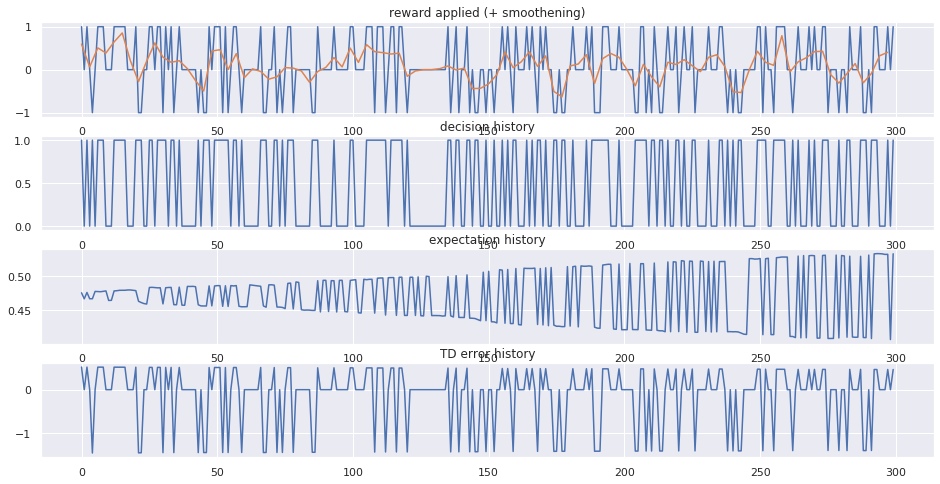

In [22]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")


## Separate plastic weights for go & no go

In [23]:
'''This spiking reservoir network class includes 2 sets of plastic readout 
(output) weights.  One set of weights corresponds to go, and the other to nogo.
They are not constrained to be either fully positive or fully negative.'''
class SpikingReservoir_v2(SpikingReservoir_v1):

  def init_output_weights(self, nodes, output_dim):
    W_go = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
    W_nogo = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
    
    # According to the paper: normalize according to the squared sum of the weights for each output node.
    W_go /= np.linalg.norm(W_go)
    W_nogo /= np.linalg.norm(W_nogo)

    self.go_weights = W_go
    self.nogo_weights = W_nogo

  def step(self, I=0):
    if np.array_equal(I, 0):
        I = np.zeros(self.w_input.shape[0])

    tau = self.params['tau']
    dt = self.params['dt']
    g = self.params['network gain']
    sigma_noise = self.params['noise gain']
    y_0 = self.params['base firing rate']
    y_max = self.params['max firing rate']

    white_noise = np.random.randint(0, high=(1 + 1), size=self.x.size)

    dx_dt = 1/tau * (-self.x + g * np.dot(self.hidden_weights, self.y) 
                     + np.dot(self.w_input.T, I) 
                     + sigma_noise * white_noise)
    self.x += dx_dt * dt

    y_conditions =[self.x <= 0, self.x > 0]
    y_functions =[
        lambda x: y_0 + y_0 * np.tanh(x/y_0),
        lambda x: y_0 + (y_max - y_0) * np.tanh(x/(y_max - y_0))
    ]
    self.y = np.piecewise(self.x, y_conditions, y_functions)

    v = np.dot(self.y, self.go_weights) - np.dot(self.y, self.nogo_weights)
    p = sigmoid_avg(v, 1)[0]
    self.exp_r = p
    self.z = np.random.choice([0, 1], p=[1-p, p])

    return self.z

  def receive_reward(self, r):
    self.step()
    self.update_weights(r)
  
  def update_weights(self, r):
    if r == 1:
      delta_w = self.params['learning rate'] * np.outer((r - self.exp_r),
              (self.y - self.params['training threshold']))
      delta_w = np.multiply(delta_w.T, self.z)
      self.go_weights -= delta_w
      self.go_weights /= np.linalg.norm(self.go_weights)
    elif r == -1:
      delta_w = self.params['learning rate'] * np.outer((r - self.exp_r),
               (self.y - self.params['training threshold']))
      delta_w = np.multiply(delta_w.T, self.z)
      self.nogo_weights += delta_w
      self.nogo_weights /= np.linalg.norm(self.nogo_weights)
  
  def get_output(self, exp=False):
    if exp:
        return self.z, self.exp_r
    else:
        return self.z

In [24]:
net = SpikingReservoir_v2(500, 2, reservoir_network_params)
r_hist, decision_hist, exp_hist = simple_experiment(T=1000, num_trials=300, 
                              net=net, I=I, contingency=I2A_1)


In [25]:
# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist)

Text(0.5, 1.0, 'TD error history')

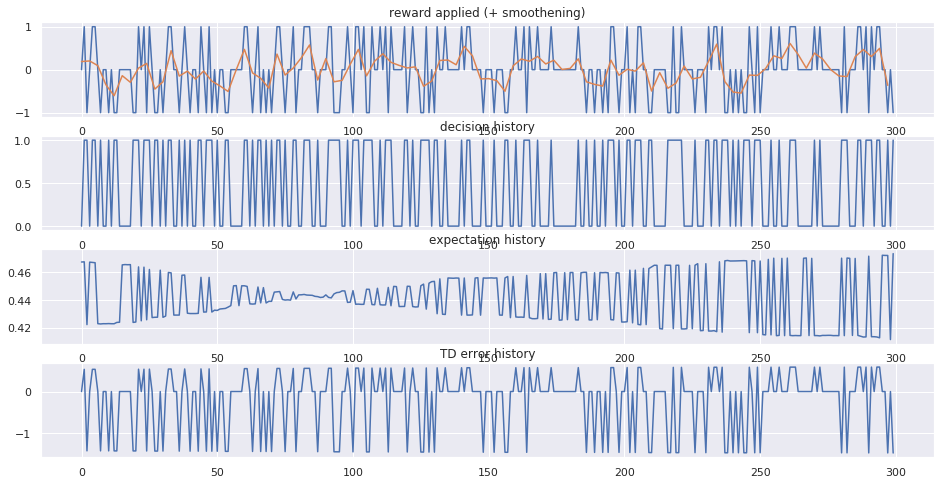

In [26]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")

In [50]:
''' This is a very naive implementation of the separate go / nogo pathways.
It creates 1 excitatory and 1 inhibitory reservoir that are connected 
to each other.  More refinement will be needed.'''

class SpikingReservoir_v3(SpikingReservoir_v1):
  def __init__(self, nodes, input_dim, params, output_dim=1, sparse=True):
    super().__init__(nodes, input_dim, params, output_dim, sparse)
    self.y = np.zeros((2, nodes))
    
  def init_neurons(self, nodes):
    std_dev = self.params['initial noise gain'] # The paper uses a variance of sigma_ini^2
    x_exc = np.random.normal(loc=0.0, scale=std_dev, size=nodes)
    x_inh = np.random.normal(loc=0.0, scale=std_dev, size=nodes)
    
    self.x = np.array([x_exc, x_inh])
  def init_output_weights(self, nodes, output_dim):
    # Readout weights from each reservoir.
        
    w_exc_go = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
    w_inh_go = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
    w_exc_nogo = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
    w_inh_nogo = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))

    self.w_exc_go = w_exc_go  
    self.w_inh_go = w_inh_go
    self.w_exc_nogo = w_exc_nogo
    self.w_inh_nogo = w_inh_nogo
  
  def init_hidden_weights(self, nodes):
    # Recursive weights for reservoir feedback.
    g = self.params['initial noise gain']
    p = self.params['hidden layer prob']
    std_dev = g / np.sqrt(p * nodes) # The paper uses a variance of g^2/(p*N)

    w_exc_exc = np.random.normal(loc=0.0, scale=std_dev, size=(nodes, nodes))
    w_exc_inh = np.random.normal(loc=0.0, scale=std_dev, size=(nodes, nodes))
    w_inh_exc = np.random.normal(loc=0.0, scale=std_dev, size=(nodes, nodes))

    W = [w_exc_exc, w_exc_inh, w_inh_exc]
    if self.sparse:
      for i in range(len(W)):
        indices = np.random.choice([0, 1], size=W[i].shape, p=[1 - p, p])
        W[i] = np.multiply(W[i], indices)
    
    self.w_exc_exc = w_exc_exc
    self.w_exc_inh = w_exc_inh
    self.w_inh_exc = w_inh_exc
  
  def step(self, I=0):
    if np.array_equal(I, 0):
        I = np.zeros(self.w_input.shape[0])

    # Parameter specifications.
    tau = self.params['tau']
    dt = self.params['dt']
    g = self.params['network gain']
    sigma_noise = self.params['noise gain']
    y_0 = self.params['base firing rate']
    y_max = self.params['max firing rate']

    white_noise = np.random.randint(0, high=(1 + 1), size=self.x.shape[1])

    # Reservoir interactions.
    dx_dt_exc = 1/tau * (-self.x[0] \
                         + g * np.dot(self.w_exc_exc, self.x[0]) \
                         - g * np.dot(self.w_inh_exc, self.x[1])
                         + np.dot(self.w_input.T, I)  \
                         + sigma_noise * white_noise)
    
    dx_dt_inh = 1/tau * (-self.x[1] \
                         + g * np.dot(self.w_exc_inh, self.x[0]) \
                         + np.dot(self.w_input.T, I)  \
                         + sigma_noise * white_noise)
    
    
    self.x[0] += dx_dt_exc * dt
    self.x[1] += dx_dt_inh * dt
    
    # Reservoir neurons firing rate.
    
    for i in range(self.x.shape[0]):
      y_conditions = [self.x[i] <= 0, self.x[i] > 0]
      y_functions =[
          lambda x: y_0 + y_0 * np.tanh(x/y_0),
          lambda x: y_0 + (y_max - y_0) * np.tanh(x/(y_max - y_0))
      ]
      self.y[i] = np.piecewise(self.x[i], y_conditions, y_functions)

    # TODO: Vectorize the above loop: y = firing_rate(x).
    # TODO: Vectorize the output weights: v = W*y.
    
    # TODO: This entire output sequence needs to be revised.
    # TODO: Revise interactions between exc and inh reservoirs
    # and the output.
    v_go = np.dot(self.y, self.w_exc_go) - np.dot(self.y, self.w_inh_go)
    v_nogo= np.dot(self.y, self.w_exc_nogo) - np.dot(self.y, self.w_inh_nogo)
    v = v_go - v_nogo 
    p = sigmoid_avg(v, 1)[0][0]
    self.exp_r = p
    self.z = np.random.choice([0, 1], p=[1-p, p])
    
  def receive_reward(self, r):
    self.step()
    self.update_weights(r)
  
  def update_weights(self, r):
    # TODO: Excitatory and inhibitory weights need to have different learning
    # rules.  Their update interactions also need to be clarified.
    if self.z:
      delta_w = self.params['learning rate'] * np.outer((r - self.exp_r),
              (self.y[0] - self.params['training threshold']))
      delta_w = np.multiply(delta_w.T, self.z)
      self.w_exc_go -= delta_w
      self.w_exc_go /= np.linalg.norm(self.w_exc_go)
    else:
      delta_w = self.params['learning rate'] * np.outer((r - self.exp_r),
               (self.y[1] - self.params['training threshold']))
      delta_w = np.multiply(delta_w.T, self.z)
      self.w_inh_go -= delta_w
      self.w_inh_go /= np.linalg.norm(self.w_inh_go)
    #self.output_weights = (self.output_weights + delta_w).clip(min=0)
    
    # Normalize weights
    #self.output_weights /= np.linalg.norm(self.output_weights)

    return self.z
    

In [51]:
net = SpikingReservoir_v3(500, 2, reservoir_network_params)
r_hist, decision_hist, exp_hist = simple_experiment(T=1000, num_trials=300, 
                              net=net, I=I, contingency=I2A_1)


In [52]:
# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist)

Text(0.5, 1.0, 'TD error history')

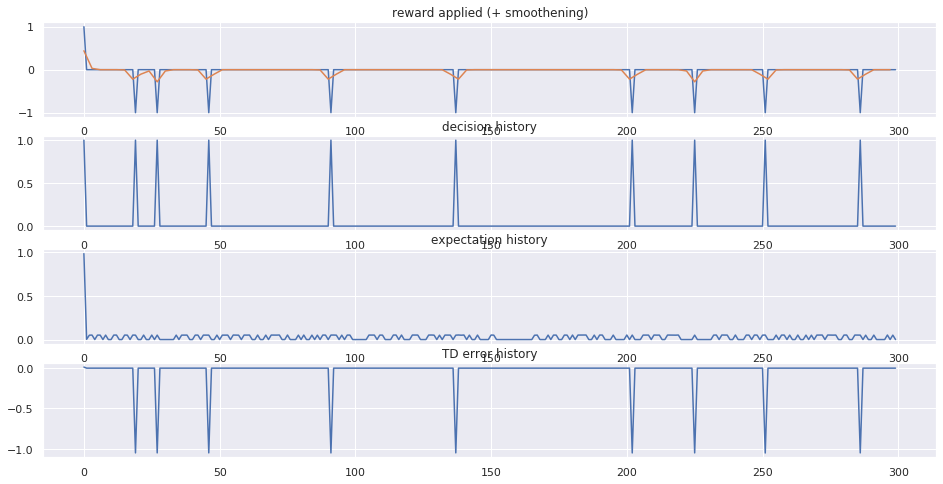

In [53]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")